In [2]:
import pandas as pd

In [3]:
test_path = 'dataset/fraudTest.csv'
train_path = 'dataset/fraudTrain.csv'
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [59]:
df_train.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [84]:
X = df_train.drop(columns=["Unnamed: 0","first","last","street","city","state","zip","is_fraud","cc_num","unix_time","trans_num"])
y = df_train["is_fraud"]
X_test = df_test.drop(columns=["Unnamed: 0","first","last","street","city","state","zip","is_fraud","cc_num","unix_time","trans_num"])
y_test = df_test["is_fraud"]

In [85]:
X["age"] = (pd.to_datetime(X["trans_date_trans_time"]) - pd.to_datetime(X["dob"])).dt.days // 365
X_test["age"] = (pd.to_datetime(X_test["trans_date_trans_time"]) - pd.to_datetime(X_test["dob"])).dt.days // 365

In [86]:
X.drop(columns=["trans_date_trans_time","dob"],inplace=True)
X_test.drop(columns=["trans_date_trans_time","dob"],inplace=True)

Initial attempt at using binary encodings - implicit relationship between distinct features

In [64]:
from sklearn import preprocessing
import category_encoders as ce
encodings = ["merchant", "category", "gender", "job"]
# Copy the original DataFrame
X_be = X.copy()

# Apply binary or label encoding as appropriate
binary_encoder_cols = []
for col in encodings:
    if X_be[col].nunique() <= 2:
        le = preprocessing.LabelEncoder()
        X_be[col] = le.fit_transform(X_be[col])
    else:
        binary_encoder_cols.append(col)

# Apply binary encoding to columns with more than 2 categories
if binary_encoder_cols:
    be = ce.BinaryEncoder(cols=binary_encoder_cols)
    X_be = be.fit_transform(X_be)

In [80]:
from sklearn import preprocessing
import category_encoders as ce
encodings = ["merchant", "category", "gender", "job"]
# Copy the original DataFrame
X_be_test = X_test.copy()

# Apply binary or label encoding as appropriate
binary_encoder_cols = []
for col in encodings:
    if X_be_test[col].nunique() <= 2:
        le = preprocessing.LabelEncoder()
        X_be_test[col] = le.fit_transform(X_be_test[col])
    else:
        binary_encoder_cols.append(col)

# Apply binary encoding to columns with more than 2 categories
if binary_encoder_cols:
    be = ce.BinaryEncoder(cols=binary_encoder_cols)
    X_be_test = be.fit_transform(X_be_test)

Second attempt using one-hot encodings

In [55]:
for feature in X.columns:
    print(f"Column {feature} has {X[feature].nunique()} features")

Column merchant has 693 features
Column category has 14 features
Column amt has 52928 features
Column gender has 2 features
Column lat has 968 features
Column long has 969 features
Column city_pop has 879 features
Column job has 494 features
Column merch_lat has 1247805 features
Column merch_long has 1275745 features
Column age has 83 features


In [13]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop(columns=feature_to_encode)
    return(res)

In [14]:
res = X.copy()
encodings = ["merchant", "category", "gender", "job"]
for feature in encodings:
    res = encode_and_bind(res, feature)

Target encoding implementation

In [87]:
encodings = ["merchant", "category", "gender", "job"]
X_y = pd.concat([X,y], axis = 1)
for feature in encodings:
    means = X_y.groupby(feature)["is_fraud"].sum()
    X_y[feature] = X_y[feature].map(means)

In [88]:
X_be = X_y.drop(columns="is_fraud")
y = X_y["is_fraud"]

In [89]:
encodings = ["merchant", "category", "gender", "job"]
X_y = pd.concat([X_test,y_test], axis = 1)
for feature in encodings:
    means = X_y.groupby(feature)["is_fraud"].sum()
    X_y[feature] = X_y[feature].map(means)

In [90]:
X_be_test = X_y.drop(columns="is_fraud")
y_test = X_y["is_fraud"]

should normalize

In [ ]:
""" from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_be["city_pop"] = scaler.fit_transform(X_be[["city_pop"]]) """

In [91]:
from sklearn.preprocessing import StandardScaler
Z_norm = StandardScaler()
X_be["city_pop"] = Z_norm.fit_transform(X_be[["city_pop"]])

In [92]:
Z_norm = StandardScaler()
X_be_test["city_pop"] = Z_norm.fit_transform(X_be_test[["city_pop"]])

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import random

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [96]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_be, y, test_size=0.2, random_state=42, stratify=y
)

In [97]:
seed_value = 117
random.seed(seed_value)


# Build the model
model = Sequential()

model.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))

model.add(Dense(units=128, activation='relu'))

model.add(Dense(units=64, activation='relu'))

model.add(Dense(units=1, activation='sigmoid'))

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [98]:
from keras.metrics import Recall, Precision, AUC
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=[Recall(name = "recall"), Precision(name = "precision"), AUC(name = "auc")])

Before applying weights to positive samples we want to balance the dataset using SMOTE - generates a significant number of samples doubling dataset size which is undesirable

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy=0.2, random_state=1)),
    ('undersample', RandomUnderSampler(sampling_strategy=0.8))
])

X_smote, y_smote = pipeline.fit_resample(X_be, y)

Attempting to use weights to give more importance to positive samples

In [102]:
from sklearn.utils import class_weight
import numpy as np
# If y is a (n_samples, 1) array of 0/1 labels:
y_flat = y.ravel()  # shape = (n_samples,)
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_flat
)
class_weight_dict = {0: weights[0], 1: weights[1]}
class_weight_dict = {0:1, 1:5}
print(class_weight_dict)  # e.g. {0: 0.48, 1: 10.7}

{0: 1, 1: 5}


C:\Users\User\AppData\Local\Temp\ipykernel_30156\458536342.py:4: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_flat = y.ravel()  # shape = (n_samples,)


In [103]:
model_fit = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), verbose = 1, class_weight = class_weight_dict)

Epoch 1/10
16209/16209 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - auc: 0.8148 - loss: 1.0958 - precision: 0.1898 - recall: 0.2774 - val_auc: 0.8302 - val_loss: 0.0322 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
16209/16209 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - auc: 0.8077 - loss: 0.0943 - precision: 0.1530 - recall: 0.0986 - val_auc: 0.4998 - val_loss: 0.0511 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
16209/16209 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - auc: 0.5523 - loss: 0.1338 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.5001 - val_loss: 0.0465 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
16209/16209 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - auc: 0.4988 - loss: 0.1330 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.5000 - val_loss: 0.0500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
16209/16209 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - auc: 0.4953 - loss: 0.1327 - precision: 0.0000e+00 - recall: 0.0000e+00 -

In [104]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,229 (204.02 KB)

 Trainable params: 17,409 (68.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,820 (136.02 KB)

In [105]:
y_pred = model.predict(X_be_test) 

17367/17367 ━━━━━━━━━━━━━━━━━━━━ 8s 436us/step


In [106]:
y_pred

array([[0.02596949],
       [0.02596949],
       [0.02596949],
       ...,
       [0.02596949],
       [0.02596949],
       [0.02596949]], dtype=float32)

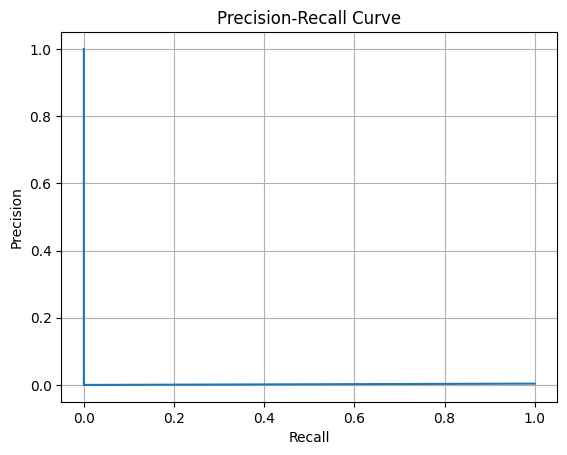

In [107]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras_tuner as kt

In [ ]:

# Perform SMOTE oversampling
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=1)
X_train_smote, y_train_smote = smote.fit_resample(X_be, y)

# Define a model-building function
def build_model(hp):
    model = Sequential()
    
    # Tune the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=8, max_value=128, step=8)
    # Tune the activation function for the first Dense layer
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    model.add(Dense(units=hp_units, activation=hp_activation, input_shape=(X_be.shape[1],)))
  
    # Tune the number of units in the second Dense layer
    hp_units_2 = hp.Int('units_2', min_value=0, max_value=64, step=8)
    model.add(Dense(units=hp_units_2, activation=hp_activation))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),loss='binary_crossentropy', metrics=['f1_score'])
    
    return model

# Instantiate the tuner using GridSearch
tuner = kt.RandomSearch(
    build_model,
    objective='val_f1_score',
    max_trials=200,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to build and fit for each trial
    seed=117,
    directory='my_dir',
    project_name='random_search_kt',
    overwrite=True
)

# Perform the hyperparameter search
tuner.search(X_train_smote, y_train_smote, epochs=50, validation_split=0.2, verbose=1)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]


best_model.summary()
best_model.save("best_nn_class.keras")

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
32                |32                |units
sigmoid           |sigmoid           |activation
64                |64                |units_2
0.001             |0.001             |learning_rate

Epoch 1/50
64459/64459 ━━━━━━━━━━━━━━━━━━━━ 66s 1ms/step - f1_score: 0.5454 - loss: 0.4031 - val_f1_score: 1.0000 - val_loss: 0.5168
Epoch 2/50
64459/64459 ━━━━━━━━━━━━━━━━━━━━ 75s 1ms/step - f1_score: 0.5459 - loss: 0.3234 - val_f1_score: 1.0000 - val_loss: 0.4305
Epoch 3/50
64459/64459 ━━━━━━━━━━━━━━━━━━━━ 73s 1ms/step - f1_score: 0.5455 - loss: 0.3104 - val_f1_score: 1.0000 - val_loss: 0.4354
Epoch 4/50
64459/64459 ━━━━━━━━━━━━━━━━━━━━ 69s 1ms/step - f1_score: 0.5453 - loss: 0.2940 - val_f1_score: 1.0000 - val_loss: 0.3627
Epoch 5/50
64459/64459 ━━━━━━━━━━━━━━━━━━━━ 68s 1ms/step - f1_score: 0.5455 - loss: 0.2857 - val_f1_score: 1.0000 - val_loss: 0.4954
Epoch 6/50
64459/64459 ━━━━━━━━━━━━━━━━━━━━ 72s 1ms/step - f1_s

KeyboardInterrupt: 